# 0.0. Imports

Ao decorrer da análise teremos que fazer algumas importações de bibliotecas, no final de tudo vamos reunir todos os imports na cell abaixo.

In [1]:
# manipulação de dados
import pandas as pd
import numpy as np
# dataviz
import matplotlib.pyplot as plt
plt.style.use('dracula')
import seaborn as sns
# cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler 

# 1.0. Dados

## 1.1. Importando o Dataset

In [2]:
# importando dados
df = pd.read_excel('Dataset/cerveja.xlsx')
df.head()

,id,rating,beer,origin,avail,price,cost,calories,sodium,alcohol,class,light
0,1,VeryGood,BUDWEISER,USA,National,2.59,0.43,144,15,4.7,Premium,NONLIGHT
1,2,VeryGood,SCHLITZ,USA,National,2.59,0.43,151,19,4.9,Premium,NONLIGHT
2,3,VeryGood,LOWENBRAU,USA,National,2.89,0.48,157,15,4.9,Super-premium,NONLIGHT
3,4,VeryGood,KRONENBOURG,France,Regional,4.39,0.73,170,7,5.2,Not given,NONLIGHT
4,5,VeryGood,HEINEKEN,Holland,National,4.59,0.77,152,11,5.0,Not given,NONLIGHT


## 1.2. Leitura de Dados

### 1.2.1. Shape

In [3]:
print('Nosso dataset possui {} colunas e {} linhas'
.format(df.shape[1], df.shape[0]))

Nosso dataset possui 12 colunas e 20 linhas


### 1.2.2. Estrutura e Tipo de Dados

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20 non-null     int64  
 1   rating    20 non-null     object 
 2   beer      20 non-null     object 
 3   origin    20 non-null     object 
 4   avail     20 non-null     object 
 5   price     20 non-null     float64
 6   cost      20 non-null     float64
 7   calories  20 non-null     int64  
 8   sodium    20 non-null     int64  
 9   alcohol   20 non-null     float64
 10  class     20 non-null     object 
 11  light     20 non-null     object 
dtypes: float64(3), int64(3), object(6)
memory usage: 2.0+ KB


1. Não temos dados faltantes;
2. Não será preciso mudar o formato das variáveis;
3. Não precisaremos mudar o nome das variáveis (prefiro tudo em minúsculo)

### 1.2.3. Análise Descritiva

#### a) Atributos numéricos

In [5]:
# selecionar os atributos numéricos
num_attr = df.select_dtypes(exclude='object')

# descrever e inverter o formato 
describe = num_attr.describe().T

# adicionar novas leituras estatísticas 
describe['range'] = (num_attr.max() - num_attr.min()).tolist()
describe['unique val.'] = num_attr.nunique()
describe['variation coefficient'] = np.round((num_attr.std() / num_attr.mean()), 4).tolist()
describe['skew'] = np.round(num_attr.skew(), 4).tolist()
describe['kurtosis'] = np.round(num_attr.kurtosis(), 4).tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,unique val.,variation coefficient,skew,kurtosis
id,20.0,10.5000,5.916080,1.00,5.75,10.50,15.250,20.00,19.00,20,0.5634,0.0000,-1.2000
price,20.0,2.9740,0.861152,1.69,2.58,2.64,2.915,4.75,3.06,17,0.2896,1.2285,0.4301
cost,20.0,0.4965,0.143757,0.28,0.43,0.44,0.485,0.79,0.51,14,0.2895,1.2153,0.4245
calories,20.0,132.4000,30.257491,68.00,110.25,144.00,150.250,175.00,107.00,18,0.2285,-0.8970,-0.0436
sodium,20.0,14.9500,6.581273,6.00,9.50,15.00,19.000,27.00,21.00,11,0.4402,0.1974,-1.0811
alcohol,20.0,4.4400,0.759778,2.30,4.20,4.65,4.900,5.50,3.20,13,0.1711,-1.5458,2.7171


1. calories e sodium possuem alta variação de desvio padrão;
2. calories e sodium possuem baixo skew;
3. alcohol e sodium possuem kurtosis alta.

A **padronização** de conjuntos de dados é um requisito comum para muitos estimadores de aprendizado de máquina implementados no scikit-learn; eles podem se comportar mal se os recursos individuais não se parecem mais ou menos com dados normalmente distribuídos padrão: Gaussiano com média zero e variância unitária. Na prática, muitas vezes ignoramos a forma da distribuição e apenas transformamos os dados para centralizá-los removendo o valor médio de cada recurso e, em seguida, dimensionamos dividindo os recursos não constantes por seu desvio padrão.

#### b) Atributos categóricos

In [6]:
cat_attr = df.select_dtypes(include=['object'])
cat_attr.describe().T

,count,unique,top,freq
rating,20,3,Good,10
beer,20,20,BUDWEISER,1
origin,20,5,USA,16
avail,20,2,Regional,11
class,20,4,Not given,11
light,20,2,NONLIGHT,13


# 2.0. EAD - Análise Exploratório de Dados

## 2.1. Variáveis Numéricas

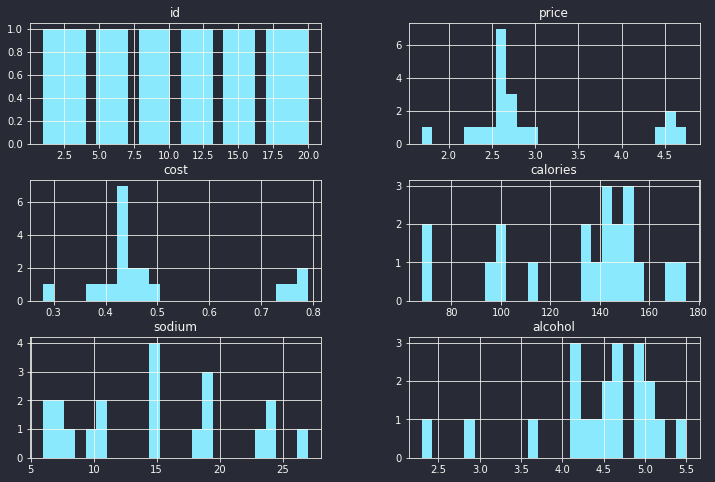

In [7]:
# Plot numerical
num_attr.hist(figsize=(12,8), bins=25)
plt.show()

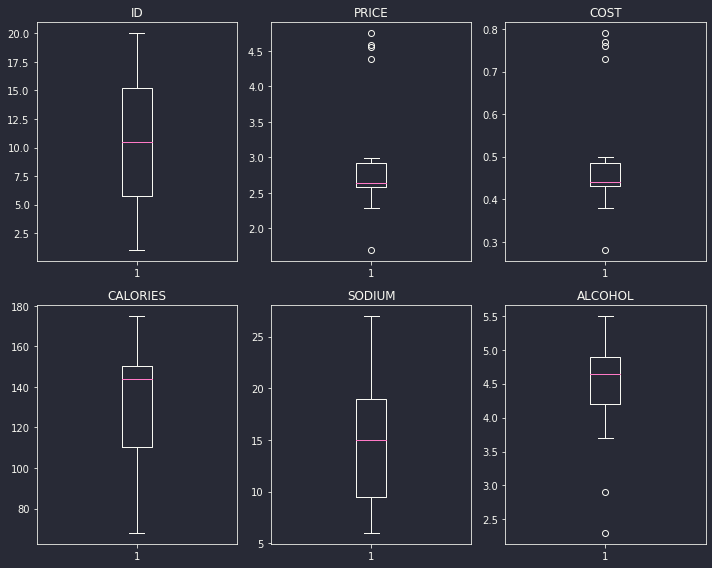

In [8]:
plt.figure(figsize=(10,8))
for i in range(len(num_attr.columns)):
    plt.subplot(2, 3, i+1) 
    plt.boxplot(num_attr[num_attr.columns[i]])
    plt.title(f'{str(num_attr.columns[i]).upper()}')
    plt.tight_layout()

Três variáveis possuem presença de outliers (price, cost e alcohol), iremos utilizar a técnica de padronização.

## 2.2. Variáveis Categóricas

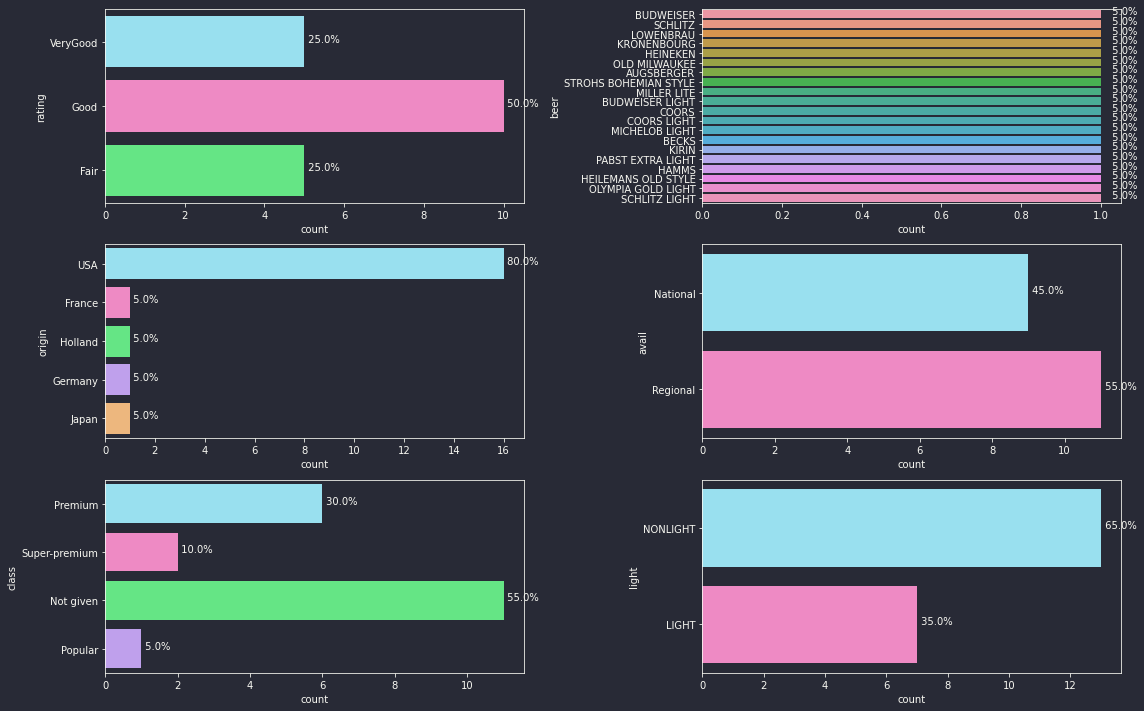

In [9]:
plt.figure(figsize=(16,10))
columns = cat_attr.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attr)
    
    total = cat_attr[column].size
    # colocar percentual nas barras
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

plt.tight_layout()
plt.show()

Algumas conclusões:
* 80% das cervejas são americanas;
* 55% das cervejas não possuem classe;

## 2.3. Análise Bivariada

a- existe um grupo de cerveja ricas em calorias.

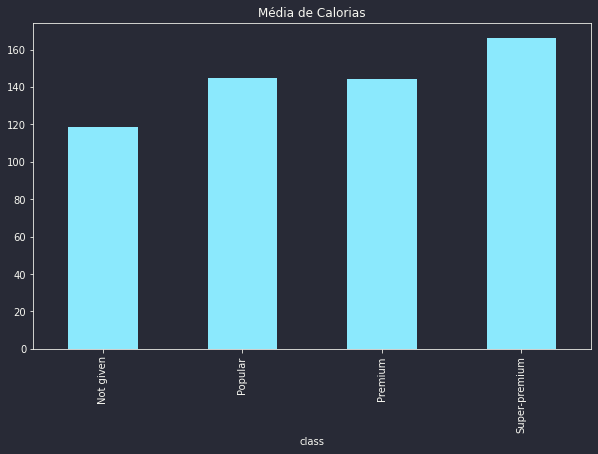

In [10]:
# selecionando variável
calorias = df[['class', 'calories']].groupby('class')['calories'].mean()

# plot
plt.figure(figsize=(10,6))
calorias.plot(kind='bar', title='Média de Calorias')
plt.show()

A super-premium em média possui maior teor alcoolico.

b- existe um grupo de cerveja ricas em álcool.

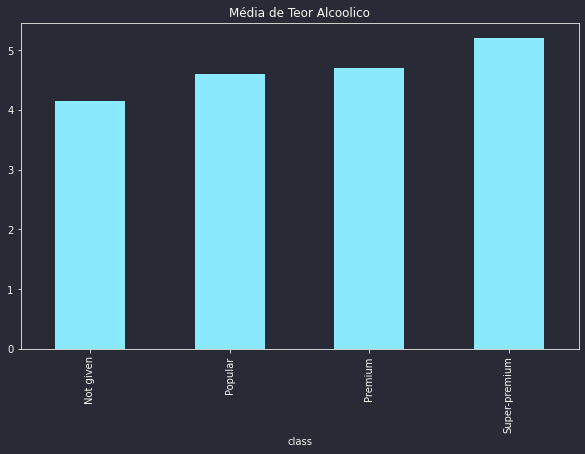

In [11]:
# selecionando variável
alcool = df[['class', 'alcohol']].groupby('class')['alcohol'].mean()

# plot
plt.figure(figsize=(10,6))
alcool.plot(kind='bar', title='Média de Teor Alcoolico')
plt.show()

c- existe um grupo de cerveja ricas em sódio.

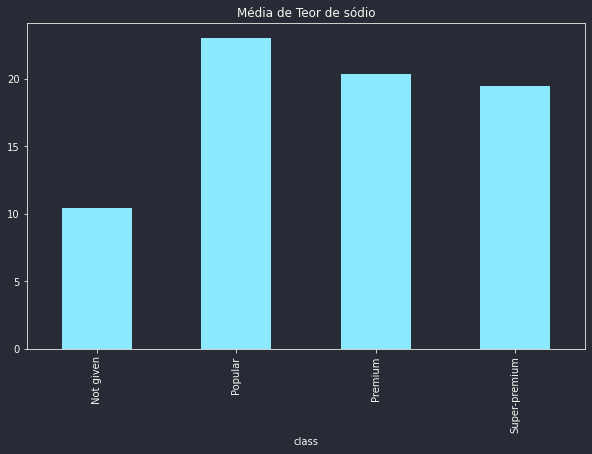

In [12]:
# selecionando variável
sodio = df[['class', 'sodium']].groupby('class')['sodium'].mean()

# plot
plt.figure(figsize=(10,6))
sodio.plot(kind='bar', title='Média de Teor de sódio')
plt.show()

d- existe um grupo de cerveja ricas em custo.

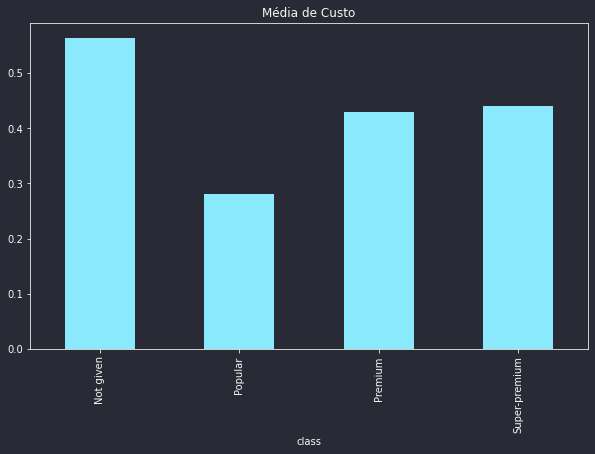

In [13]:
# selecionando variável
custo = df[['class', 'cost']].groupby('class')['cost'].mean()

# plot
plt.figure(figsize=(10,6))
custo.plot(kind='bar', title='Média de Custo')
plt.show()

## 2.4. Análise Multivariada

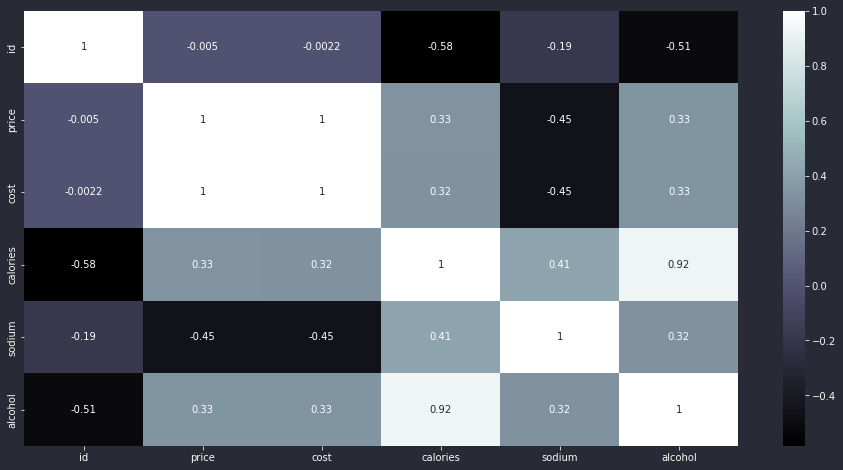

In [14]:
# Correlação por pearson method
correlation = num_attr.corr(method='pearson')

# set up figure
plt.figure(figsize=(16,8))
sns.heatmap(correlation, annot=True, cmap='bone')
plt.show()

* Existe alta correlação entre preço e custo;
* Existe alta correlação entre calorias e alcool.

# 3.0. Preparação de Dados

In [15]:
# criando cópia do dataset
df3 = num_attr.copy()

df3 = df3.drop(['id'], axis=1)

## 3.1. Label Encoding

~~Vamos transformar as variáveis categóricas em numéricas.~~[DESABILITADO]

In [16]:
#from sklearn.preprocessing import LabelEncoder
#columns = ['rating', 'origin', 'avail', 'class', 'light']

#le = LabelEncoder()
#for i in columns:
#    df3[str(i + '_lb')] = le.fit_transform(df3[str(i)])
#    df3 = df3.drop([i], axis=1)
#df3 

~~Agora que todas as variáveis estão em formato numérico, iremos padronizar.~~

## 3.2. Padronização

In [17]:
# StandardScaler - Padroniza as variáveis para média 0 e DP 1.
ss = StandardScaler()
base = ss.fit_transform(df3)

# 4.0. Cluster

## 4.1. Aglomeração

### 4.1.1. Dendrograma

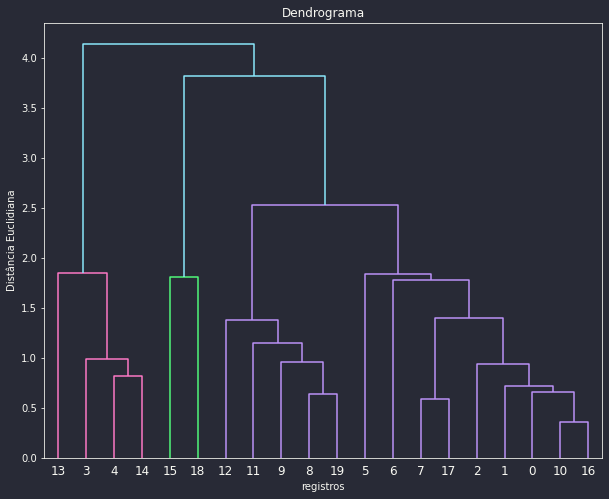

In [18]:
# Função dendograma
plt.figure(figsize=(10,8))
dendrograma = dendrogram(linkage(base, method = 'average'))
plt.title('Dendrograma')
plt.xlabel('registros')
plt.ylabel('Distância Euclidiana')

plt.show()

### 4.1.2. Método Aglomerativo

In [19]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'average')
grupo = hc.fit_predict(base)
grupo

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0])

### 4.1.3. Resultados

In [20]:
# colunas
columns = ['cost', 'calories', 'sodium', 'alcohol', 'grupo']

df4 = pd.DataFrame(base, columns=columns)

# colocar resultados no nosso dataset
df4['grupo'] = grupo

In [21]:
# agrupar pela classificação
df_den = df4[columns].groupby('grupo').mean().reset_index()
df_den

,grupo,cost,calories,sodium,alcohol
0,0,-0.466008,-0.464408,0.080895,0.286176
1,1,1.901477,1.898415,0.774803,-0.654753
2,2,-0.540896,-0.545973,-2.115874,-0.693726


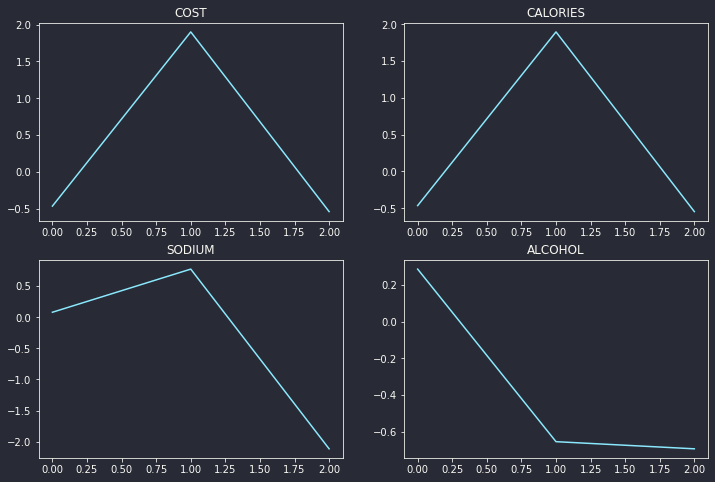

In [29]:
#plot
columns = ['cost', 'calories', 'sodium', 'alcohol']
j = 1
plt.figure(figsize=(12,8))
for i in columns:
    plt.subplot(2,2,j)
    plt.plot(df_den[i])
    plt.title(str(i).upper())
    j +=1

plt.show()

<Figure size 864x576 with 0 Axes>

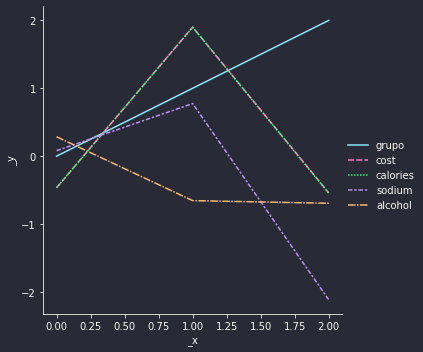

In [28]:
plt.figure(figsize=(12,8))
sns.relplot(data=df_den, kind='line')
#plt.legend(columns)
plt.show()